In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU, Dropout
from keras.layers import Activation, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose # DCGAN layers
from keras import regularizers

from keras.models import Sequential
from keras.optimizers import Adam

# Preprocessing:

## Load Dataset:

In [2]:
(x_train, _),(x_test, _) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Concat train & test data:

In [3]:
# to have more data for train
real_data = np.concatenate([x_train, x_test], axis=0)
real_data.shape

(70000, 28, 28)

## Normalize & Extend(dim) data:

In [4]:
normalized_real_data = np.expand_dims(real_data/127.5 - 1.0, axis=3)

# Define Networks:

In [5]:
def generator(zdim):
    """ Generator Network """
    model = Sequential()

    model.add(Dense(7*7*256, use_bias=False, input_shape=(zdim,))) # >>> (12544, 1, 1)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256))) # >>> (7, 7, 256)

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # >>> (7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # >>> (14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # >>> (28, 28, 1)

    return model


In [6]:
def discriminator(img_shape):
    """ Discriminator Network """
    model = Sequential()

    # Input >>> (28, 28, 1)
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape)) # >>> (14, 14, 64)
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same')) # >>> (7, 7, 128)
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten()) # >>> 7 * 7 * 128
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [7]:
def define_gan(gen, dis):
    """ Generative Adversarial Network """
    model = Sequential()
    model.add(gen)
    model.add(dis)

    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer
      )

    return model

## Set Shapes:

In [8]:
z_dim = 100
img_shape = (real_data.shape[1], real_data.shape[2], 1) # (28, 28, 1)
img_shape

(28, 28, 1)

## Call Networks:

In [9]:
dis = discriminator(img_shape)
gen = generator(z_dim)

dis.trainable = False
GAN = define_gan(gen, dis)

# Train Model:

## Useful Tools:

In [10]:
def show_images(gen, zdim):
    """ Show output samples """
    number_of_imgs = 16
    wh = int(np.sqrt(number_of_imgs))

    z = np.random.normal(0, 1, (number_of_imgs, zdim))
    gen_imgs = gen.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(wh, wh, figsize=(wh, wh), sharey=True, sharex=True)

    c = 0
    for i in range(wh):
        for j in range(wh):
            axs[i, j].imshow(gen_imgs[i*4 + j], cmap='gray')
            axs[i, j].axis('off')
            c += 1

    plt.tight_layout()
    plt.show()

## Define operation algorithm:

In [11]:
losses = []
accuracies = []
iter_checks = []

def train(r_data, gen, dis, GAN, zdim, iters_range, batch_size, interval):
    r_labels = np.ones((batch_size, 1))
    f_labels = np.zeros((batch_size, 1))

    for iter in range(iters_range):
        print(f"------------------{iter+1}------------------")
        random_index_array = np.random.randint(0, r_data.shape[0], batch_size) # array of random indexs
        r_imgs = r_data[random_index_array]

        z = np.random.normal(0, 1, (batch_size, zdim))
        f_imgs = gen.predict(z)

        r_dloss = dis.train_on_batch(r_imgs, r_labels)
        f_dloss = dis.train_on_batch(f_imgs, f_labels)

        dloss, acc = np.add(r_dloss, f_dloss) * 0.5

        z = np.random.normal(0, 1, (batch_size, zdim))
        gloss = GAN.train_on_batch(z, r_labels)

        if (iter + 1) % interval == 0:
            losses.append((dloss, gloss))
            accuracies.append(100.0*acc)
            iter_checks.append(iter+1)

            print(
                "%d --> D loss[%f] acc[%.2f] | G loss[%f]"
                % (iter + 1, dloss, 100.0 * acc, gloss)
            )

            show_images(gen, zdim)


## Start training:

------------------1------------------
8/8 [==============================] - 0s 16ms/step
------------------2------------------
8/8 [==============================] - 0s 14ms/step
------------------3------------------
8/8 [==============================] - 0s 13ms/step
------------------4------------------
8/8 [==============================] - 0s 14ms/step
------------------5------------------
8/8 [==============================] - 0s 13ms/step
------------------6------------------
8/8 [==============================] - 0s 12ms/step
------------------7------------------
8/8 [==============================] - 0s 13ms/step
------------------8------------------
8/8 [==============================] - 0s 14ms/step
------------------9------------------
8/8 [==============================] - 0s 13ms/step
------------------10------------------
8/8 [==============================] - 0s 13ms/step
------------------11------------------
8/8 [==============================] - 0s 14ms/step
--------

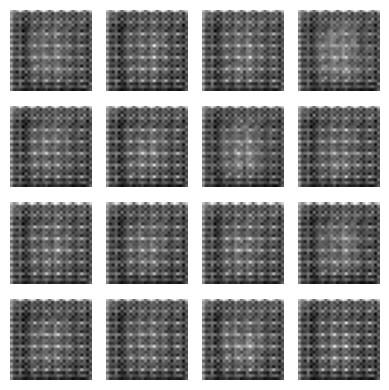

------------------101------------------
8/8 [==============================] - 0s 13ms/step
------------------102------------------
8/8 [==============================] - 0s 13ms/step
------------------103------------------
8/8 [==============================] - 0s 13ms/step
------------------104------------------
8/8 [==============================] - 0s 12ms/step
------------------105------------------
8/8 [==============================] - 0s 13ms/step
------------------106------------------
8/8 [==============================] - 0s 12ms/step
------------------107------------------
8/8 [==============================] - 0s 13ms/step
------------------108------------------
8/8 [==============================] - 0s 13ms/step
------------------109------------------
8/8 [==============================] - 0s 13ms/step
------------------110------------------
8/8 [==============================] - 0s 14ms/step
------------------111------------------
8/8 [==============================] - 0

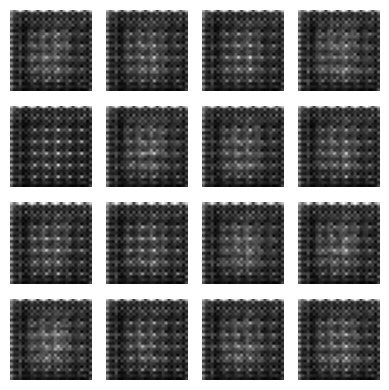

------------------201------------------
8/8 [==============================] - 0s 14ms/step
------------------202------------------
8/8 [==============================] - 0s 13ms/step
------------------203------------------
8/8 [==============================] - 0s 13ms/step
------------------204------------------
8/8 [==============================] - 0s 14ms/step
------------------205------------------
8/8 [==============================] - 0s 13ms/step
------------------206------------------
8/8 [==============================] - 0s 12ms/step
------------------207------------------
8/8 [==============================] - 0s 13ms/step
------------------208------------------
8/8 [==============================] - 0s 13ms/step
------------------209------------------
8/8 [==============================] - 0s 13ms/step
------------------210------------------
8/8 [==============================] - 0s 13ms/step
------------------211------------------
8/8 [==============================] - 0

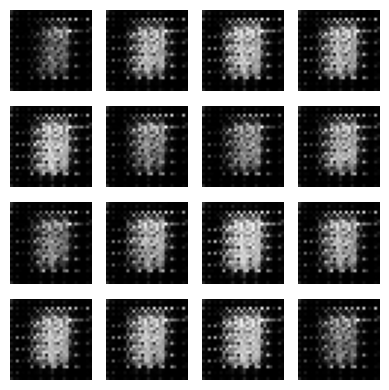

------------------301------------------
8/8 [==============================] - 0s 12ms/step
------------------302------------------
8/8 [==============================] - 0s 12ms/step
------------------303------------------
8/8 [==============================] - 0s 14ms/step
------------------304------------------
8/8 [==============================] - 0s 13ms/step
------------------305------------------
8/8 [==============================] - 0s 13ms/step
------------------306------------------
8/8 [==============================] - 0s 14ms/step
------------------307------------------
8/8 [==============================] - 0s 12ms/step
------------------308------------------
8/8 [==============================] - 0s 12ms/step
------------------309------------------
8/8 [==============================] - 0s 13ms/step
------------------310------------------
8/8 [==============================] - 0s 13ms/step
------------------311------------------
8/8 [==============================] - 0

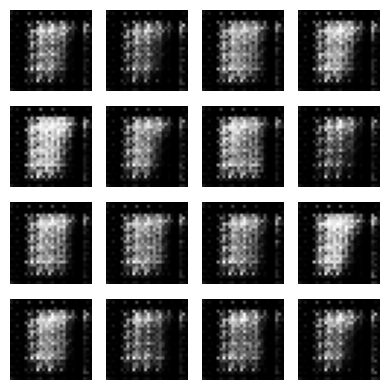

------------------401------------------
8/8 [==============================] - 0s 13ms/step
------------------402------------------
8/8 [==============================] - 0s 12ms/step
------------------403------------------
8/8 [==============================] - 0s 13ms/step
------------------404------------------
8/8 [==============================] - 0s 11ms/step
------------------405------------------
8/8 [==============================] - 0s 12ms/step
------------------406------------------
8/8 [==============================] - 0s 13ms/step
------------------407------------------
8/8 [==============================] - 0s 13ms/step
------------------408------------------
8/8 [==============================] - 0s 13ms/step
------------------409------------------
8/8 [==============================] - 0s 15ms/step
------------------410------------------
8/8 [==============================] - 0s 13ms/step
------------------411------------------
8/8 [==============================] - 0

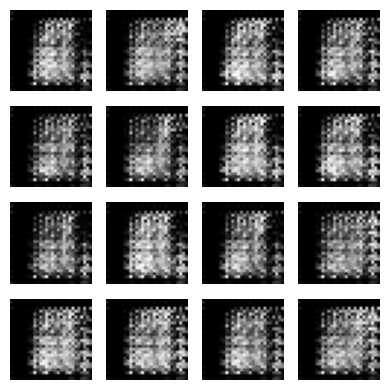

------------------501------------------
8/8 [==============================] - 0s 11ms/step
------------------502------------------
8/8 [==============================] - 0s 12ms/step
------------------503------------------
8/8 [==============================] - 0s 12ms/step
------------------504------------------
8/8 [==============================] - 0s 13ms/step
------------------505------------------
8/8 [==============================] - 0s 12ms/step
------------------506------------------
8/8 [==============================] - 0s 13ms/step
------------------507------------------
8/8 [==============================] - 0s 13ms/step
------------------508------------------
8/8 [==============================] - 0s 12ms/step
------------------509------------------
8/8 [==============================] - 0s 12ms/step
------------------510------------------
8/8 [==============================] - 0s 14ms/step
------------------511------------------
8/8 [==============================] - 0

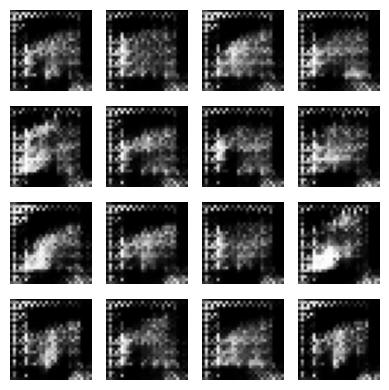

------------------601------------------
8/8 [==============================] - 0s 12ms/step
------------------602------------------
8/8 [==============================] - 0s 12ms/step
------------------603------------------
8/8 [==============================] - 0s 12ms/step
------------------604------------------
8/8 [==============================] - 0s 13ms/step
------------------605------------------
8/8 [==============================] - 0s 11ms/step
------------------606------------------
8/8 [==============================] - 0s 13ms/step
------------------607------------------
8/8 [==============================] - 0s 13ms/step
------------------608------------------
8/8 [==============================] - 0s 14ms/step
------------------609------------------
8/8 [==============================] - 0s 12ms/step
------------------610------------------
8/8 [==============================] - 0s 12ms/step
------------------611------------------
8/8 [==============================] - 0

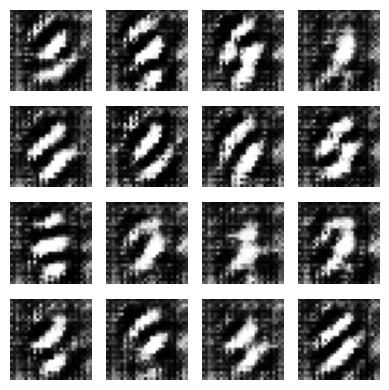

------------------701------------------
8/8 [==============================] - 0s 13ms/step
------------------702------------------
8/8 [==============================] - 0s 13ms/step
------------------703------------------
8/8 [==============================] - 0s 13ms/step
------------------704------------------
8/8 [==============================] - 0s 13ms/step
------------------705------------------
8/8 [==============================] - 0s 13ms/step
------------------706------------------
8/8 [==============================] - 0s 12ms/step
------------------707------------------
8/8 [==============================] - 0s 13ms/step
------------------708------------------
8/8 [==============================] - 0s 13ms/step
------------------709------------------
8/8 [==============================] - 0s 13ms/step
------------------710------------------
8/8 [==============================] - 0s 12ms/step
------------------711------------------
8/8 [==============================] - 0

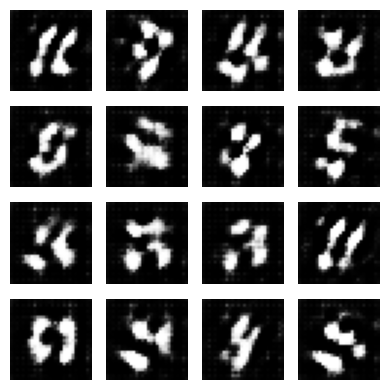

------------------801------------------
8/8 [==============================] - 0s 13ms/step
------------------802------------------
8/8 [==============================] - 0s 13ms/step
------------------803------------------
8/8 [==============================] - 0s 13ms/step
------------------804------------------
8/8 [==============================] - 0s 14ms/step
------------------805------------------
8/8 [==============================] - 0s 12ms/step
------------------806------------------
8/8 [==============================] - 0s 12ms/step
------------------807------------------
8/8 [==============================] - 0s 13ms/step
------------------808------------------
8/8 [==============================] - 0s 12ms/step
------------------809------------------
8/8 [==============================] - 0s 13ms/step
------------------810------------------
8/8 [==============================] - 0s 13ms/step
------------------811------------------
8/8 [==============================] - 0

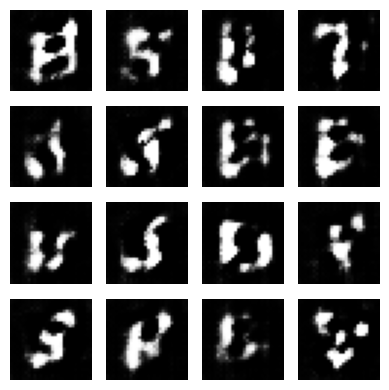

------------------901------------------
8/8 [==============================] - 0s 12ms/step
------------------902------------------
8/8 [==============================] - 0s 12ms/step
------------------903------------------
8/8 [==============================] - 0s 12ms/step
------------------904------------------
8/8 [==============================] - 0s 13ms/step
------------------905------------------
8/8 [==============================] - 0s 13ms/step
------------------906------------------
8/8 [==============================] - 0s 12ms/step
------------------907------------------
8/8 [==============================] - 0s 12ms/step
------------------908------------------
8/8 [==============================] - 0s 13ms/step
------------------909------------------
8/8 [==============================] - 0s 12ms/step
------------------910------------------
8/8 [==============================] - 0s 13ms/step
------------------911------------------
8/8 [==============================] - 0

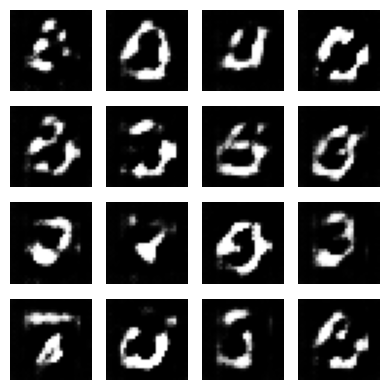

------------------1001------------------
8/8 [==============================] - 0s 13ms/step
------------------1002------------------
8/8 [==============================] - 0s 13ms/step
------------------1003------------------
8/8 [==============================] - 0s 11ms/step
------------------1004------------------
8/8 [==============================] - 0s 13ms/step
------------------1005------------------
8/8 [==============================] - 0s 13ms/step
------------------1006------------------
8/8 [==============================] - 0s 13ms/step
------------------1007------------------
8/8 [==============================] - 0s 13ms/step
------------------1008------------------
8/8 [==============================] - 0s 12ms/step
------------------1009------------------
8/8 [==============================] - 0s 13ms/step
------------------1010------------------
8/8 [==============================] - 0s 13ms/step
------------------1011------------------
8/8 [========================

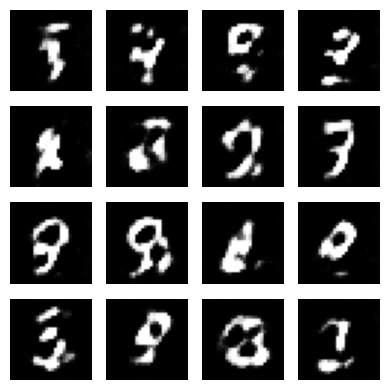

------------------1101------------------
8/8 [==============================] - 0s 13ms/step
------------------1102------------------
8/8 [==============================] - 0s 12ms/step
------------------1103------------------
8/8 [==============================] - 0s 13ms/step
------------------1104------------------
8/8 [==============================] - 0s 13ms/step
------------------1105------------------
8/8 [==============================] - 0s 13ms/step
------------------1106------------------
8/8 [==============================] - 0s 11ms/step
------------------1107------------------
8/8 [==============================] - 0s 12ms/step
------------------1108------------------
8/8 [==============================] - 0s 13ms/step
------------------1109------------------
8/8 [==============================] - 0s 13ms/step
------------------1110------------------
8/8 [==============================] - 0s 14ms/step
------------------1111------------------
8/8 [========================

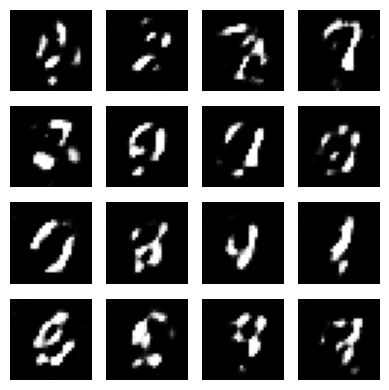

------------------1201------------------
8/8 [==============================] - 0s 13ms/step
------------------1202------------------
8/8 [==============================] - 0s 13ms/step
------------------1203------------------
8/8 [==============================] - 0s 13ms/step
------------------1204------------------
8/8 [==============================] - 0s 13ms/step
------------------1205------------------
8/8 [==============================] - 0s 12ms/step
------------------1206------------------
8/8 [==============================] - 0s 13ms/step
------------------1207------------------
8/8 [==============================] - 0s 12ms/step
------------------1208------------------
8/8 [==============================] - 0s 13ms/step
------------------1209------------------
8/8 [==============================] - 0s 13ms/step
------------------1210------------------
8/8 [==============================] - 0s 13ms/step
------------------1211------------------
8/8 [========================

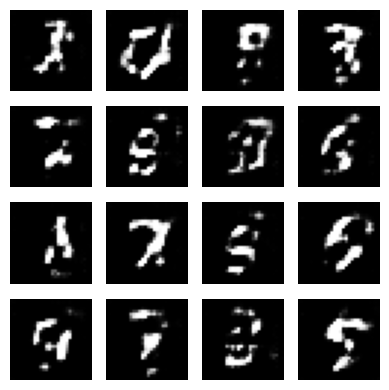

------------------1301------------------
8/8 [==============================] - 0s 14ms/step
------------------1302------------------
8/8 [==============================] - 0s 13ms/step
------------------1303------------------
8/8 [==============================] - 0s 12ms/step
------------------1304------------------
8/8 [==============================] - 0s 13ms/step
------------------1305------------------
8/8 [==============================] - 0s 12ms/step
------------------1306------------------
8/8 [==============================] - 0s 14ms/step
------------------1307------------------
8/8 [==============================] - 0s 13ms/step
------------------1308------------------
8/8 [==============================] - 0s 13ms/step
------------------1309------------------
8/8 [==============================] - 0s 12ms/step
------------------1310------------------
8/8 [==============================] - 0s 14ms/step
------------------1311------------------
8/8 [========================

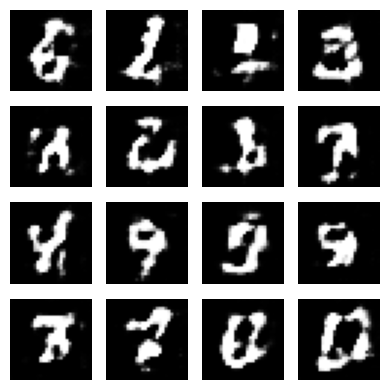

------------------1401------------------
8/8 [==============================] - 0s 14ms/step
------------------1402------------------
8/8 [==============================] - 0s 12ms/step
------------------1403------------------
8/8 [==============================] - 0s 11ms/step
------------------1404------------------
8/8 [==============================] - 0s 13ms/step
------------------1405------------------
8/8 [==============================] - 0s 13ms/step
------------------1406------------------
8/8 [==============================] - 0s 12ms/step
------------------1407------------------
8/8 [==============================] - 0s 13ms/step
------------------1408------------------
8/8 [==============================] - 0s 14ms/step
------------------1409------------------
8/8 [==============================] - 0s 12ms/step
------------------1410------------------
8/8 [==============================] - 0s 13ms/step
------------------1411------------------
8/8 [========================

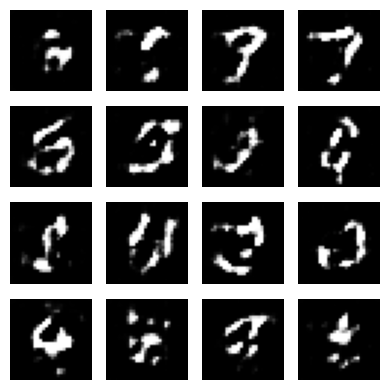

------------------1501------------------
8/8 [==============================] - 0s 13ms/step
------------------1502------------------
8/8 [==============================] - 0s 12ms/step
------------------1503------------------
8/8 [==============================] - 0s 13ms/step
------------------1504------------------
8/8 [==============================] - 0s 13ms/step
------------------1505------------------
8/8 [==============================] - 0s 13ms/step
------------------1506------------------
8/8 [==============================] - 0s 13ms/step
------------------1507------------------
8/8 [==============================] - 0s 13ms/step
------------------1508------------------
8/8 [==============================] - 0s 13ms/step
------------------1509------------------
8/8 [==============================] - 0s 14ms/step
------------------1510------------------
8/8 [==============================] - 0s 14ms/step
------------------1511------------------
8/8 [========================

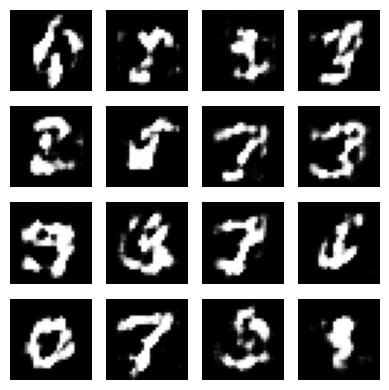

------------------1601------------------
8/8 [==============================] - 0s 12ms/step
------------------1602------------------
8/8 [==============================] - 0s 13ms/step
------------------1603------------------
8/8 [==============================] - 0s 12ms/step
------------------1604------------------
8/8 [==============================] - 0s 13ms/step
------------------1605------------------
8/8 [==============================] - 0s 13ms/step
------------------1606------------------
8/8 [==============================] - 0s 14ms/step
------------------1607------------------
8/8 [==============================] - 0s 13ms/step
------------------1608------------------
8/8 [==============================] - 0s 13ms/step
------------------1609------------------
8/8 [==============================] - 0s 14ms/step
------------------1610------------------
8/8 [==============================] - 0s 14ms/step
------------------1611------------------
8/8 [========================

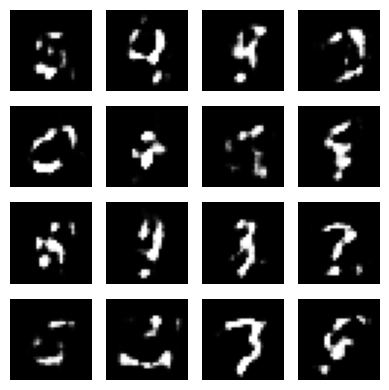

------------------1701------------------
8/8 [==============================] - 0s 12ms/step
------------------1702------------------
8/8 [==============================] - 0s 13ms/step
------------------1703------------------
8/8 [==============================] - 0s 14ms/step
------------------1704------------------
8/8 [==============================] - 0s 13ms/step
------------------1705------------------
8/8 [==============================] - 0s 13ms/step
------------------1706------------------
8/8 [==============================] - 0s 13ms/step
------------------1707------------------
8/8 [==============================] - 0s 14ms/step
------------------1708------------------
8/8 [==============================] - 0s 14ms/step
------------------1709------------------
8/8 [==============================] - 0s 13ms/step
------------------1710------------------
8/8 [==============================] - 0s 14ms/step
------------------1711------------------
8/8 [========================

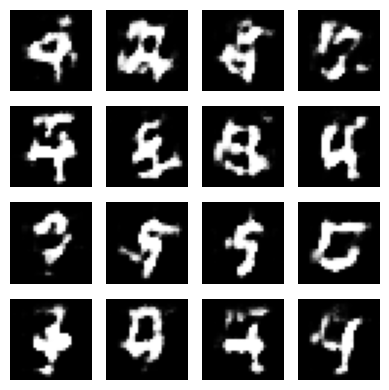

------------------1801------------------
8/8 [==============================] - 0s 13ms/step
------------------1802------------------
8/8 [==============================] - 0s 13ms/step
------------------1803------------------
8/8 [==============================] - 0s 13ms/step
------------------1804------------------
8/8 [==============================] - 0s 14ms/step
------------------1805------------------
8/8 [==============================] - 0s 14ms/step
------------------1806------------------
8/8 [==============================] - 0s 15ms/step
------------------1807------------------
8/8 [==============================] - 0s 14ms/step
------------------1808------------------
8/8 [==============================] - 0s 13ms/step
------------------1809------------------
8/8 [==============================] - 0s 14ms/step
------------------1810------------------
8/8 [==============================] - 0s 12ms/step
------------------1811------------------
8/8 [========================

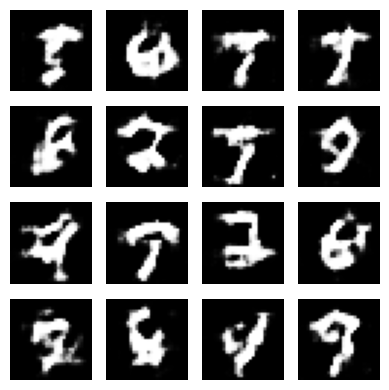

------------------1901------------------
8/8 [==============================] - 0s 13ms/step
------------------1902------------------
8/8 [==============================] - 0s 13ms/step
------------------1903------------------
8/8 [==============================] - 0s 12ms/step
------------------1904------------------
8/8 [==============================] - 0s 14ms/step
------------------1905------------------
8/8 [==============================] - 0s 13ms/step
------------------1906------------------
8/8 [==============================] - 0s 14ms/step
------------------1907------------------
8/8 [==============================] - 0s 14ms/step
------------------1908------------------
8/8 [==============================] - 0s 12ms/step
------------------1909------------------
8/8 [==============================] - 0s 13ms/step
------------------1910------------------
8/8 [==============================] - 0s 13ms/step
------------------1911------------------
8/8 [========================

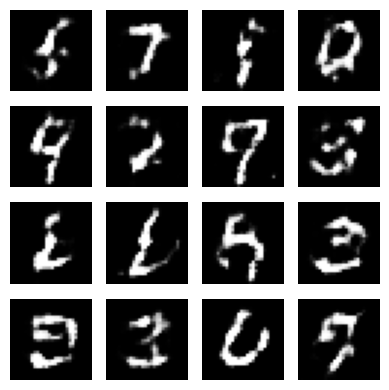

In [12]:
train(normalized_real_data, gen, dis, GAN, z_dim, 2000, 256, 100)

In [13]:
gen.save("numbers_generator_DCGAN_mnist_70000.keras")

# ***FIN :3***